In [1]:
!pip install gradio torch langchain huggingface-hub chromadb kaggle langchain_community sentence-transformers pdfplumber -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 976.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.2/599.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 20.5 MB/s et

In [2]:
#!kaggle datasets download -d ikjotsingh221/kagglefaq
#!unzip /content/kagglefaq.zip -d /content/kagglefaq/
!kaggle datasets download -d harshsinghal/aws-case-studies-and-blogs
!unzip /content/aws-case-studies-and-blogs.zip -d /content/aws-case-studies-and-blogs/



Dataset URL: https://www.kaggle.com/datasets/harshsinghal/aws-case-studies-and-blogs
License(s): unknown
 72% 1.00M/1.40M [00:00<00:00, 1.99MB/s]
100% 1.40M/1.40M [00:00<00:00, 2.54MB/s]
Archive:  /content/aws-case-studies-and-blogs.zip
  inflating: /content/aws-case-studies-and-blogs/23andMe Case Study _ Life Sciences _ AWS.txt  
  inflating: /content/aws-case-studies-and-blogs/36 new or updated datasets on the Registry of Open Data_ AI analysis-ready datasets and more _ AWS Public Sector Blog.txt  
  inflating: /content/aws-case-studies-and-blogs/54gene _ Case Study _ AWS.txt  
  inflating: /content/aws-case-studies-and-blogs/6sense Case Study.txt  
  inflating: /content/aws-case-studies-and-blogs/ADP Developed an Innovative and Secure Digital Wallet in a Few Months Using AWS Services _ Case Study _ AWS.txt  
  inflating: /content/aws-case-studies-and-blogs/AEON Case Study.txt  
  inflating: /content/aws-case-studies-and-blogs/ALTBalaji _ Amazon Web Services.txt  
  inflating: /conte

In [3]:
import os, torch
import gradio as gr
import matplotlib.pyplot as plt
import pandas as pd
import pdfplumber
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM, pipeline
from langchain.chains import RetrievalQA
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.document import Document
from langchain.llms import HuggingFacePipeline
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm



/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [ ]:
huggingface_token = input("Please enter your Hugging Face API token: ")
os.environ['HUGGINGFACE_TOKEN'] = huggingface_token

# Retrieve the Hugging Face token from the environment variable
huggingface_token = os.getenv('HUGGINGFACE_TOKEN')

if not huggingface_token:
    raise ValueError("Hugging Face token not found. Please enter the token.")


In [5]:
# Load text files from a directory
def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + "\n"
    return text

def read_text_file(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as file:
        return file.read()

In [6]:
# Example function to process all files
def process_files(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            # Create the full path to the PDF file
            pdf_path = os.path.join(directory, filename)
            documents.append(extract_text_from_pdf(pdf_path))
        elif filename.endswith('.txt'):
            # Create the full path to the text file
            txt_path = os.path.join(directory, filename)
            documents.append(read_text_file(txt_path))

    # Combine documents into a single text block (or keep them separate)
    combined_text = "\n".join(documents)

    return documents

In [7]:
# Directory containing your text files
docs_directory = "/content/aws-case-studies-and-blogs/"
#docs_directory = "/content/kagglefaq/"

# Load documents
documents = process_files(docs_directory)


In [8]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').max_seq_length}"
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 256


In [9]:
# Load the TinyLlama model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" # You can choose a different size if needed
#model_name = "facebook/opt-1.3b"
#model_name = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2781 > 2048). Running this sequence through the model will result in indexing errors


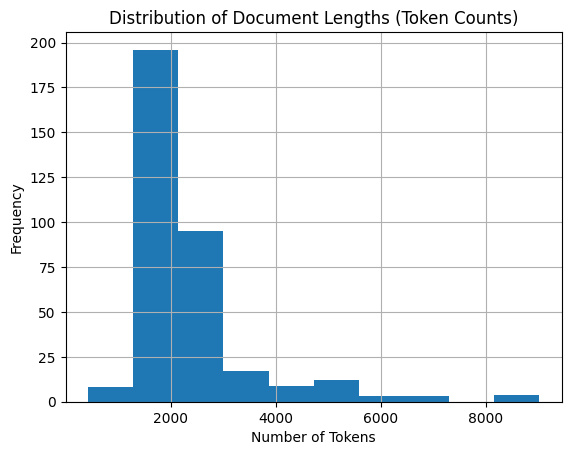

In [10]:
# Tokenize each document's text

#lengths = [len(tokenizer.encode(doc.page_content)) for doc in documents]
lengths = [len(tokenizer.encode(doc)) for doc in documents]

# Plot the distribution of document lengths (number of tokens)

fig = pd.Series(lengths).hist()
plt.title("Distribution of Document Lengths (Token Counts)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Split documents into smaller chunks (either run this cell or cell below)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=50)
# Create Langchain Document objects from the list of strings
docs = [Document(page_content=doc) for doc in documents]
split_documents = text_splitter.split_documents(docs)



In [12]:
# Initialize text splitter with Hugging Face tokenizer
text_splitter_token = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=512,  # Define maximum chunk size in tokens
    chunk_overlap=50  # Define overlap size in tokens
)

# Split documents into chunks (by token)
split_documents_token= text_splitter_token.split_documents(docs)


  0%|          | 0/2238 [00:00<?, ?it/s]

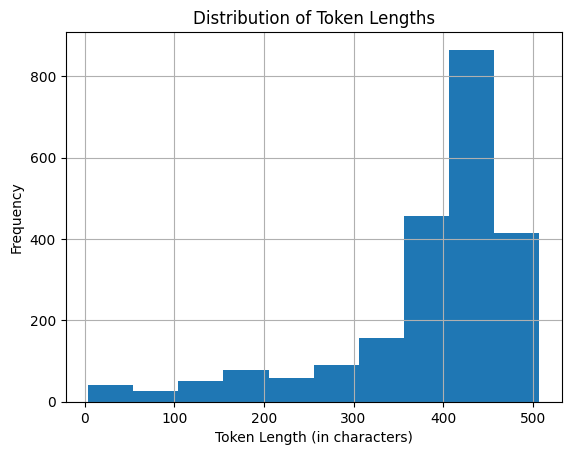

In [13]:
# Calculate the token lengths of each chunk after splitting
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(split_documents_token)]

# Plot the distribution of token lengths
fig = pd.Series(lengths).hist()  # Adjust bins for granularity
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length (in characters)")
plt.ylabel("Frequency")
plt.show()


In [14]:

# Create embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create a Chroma vector store
vector_store = Chroma.from_documents(split_documents_token, embeddings) #or include split_documents for chunk size embeddings


#model = AutoModelForSeq2SeqLM.from_pretrained(model_name) # if other selected model_name which need this function to process
model = AutoModelForCausalLM.from_pretrained(model_name,torch_dtype=torch.float16, low_cpu_mem_usage=True)

#tokenizer.save_pretrained("gpt-neo-tokenizer")
#model.save_pretrained("gpt-neo-model", max_shard_size="1000MB")
#tokenizer.save_pretrained("tinyllama-tokenizer")
#model.save_pretrained("tinyllama-model", max_shard_size="1000MB")


<ipython-input-14-82174ac1eafc>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [24]:
# Load the Hugging Face pipeline for text generation
qa_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.9,
    top_k=5,
    do_sample=True,  # Enable sampling to use temperature and top_p
    repetition_penalty=1.2,
    device='cuda',
    torch_dtype=torch.bfloat16
    #use_auth_token=huggingface_token
)

# Wrap the Hugging Face pipeline in a LangChain LLM
llm = HuggingFacePipeline(pipeline=qa_pipeline)

# Create a RetrievalQA chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever()
)


In [29]:
# Define a function to automate retrieval and generation
def automate_retrieval_and_generation(query):
    # Automatically retrieve relevant documents
    retrieved_docs = vector_store.as_retriever(search_kwargs={"k": 5}).get_relevant_documents(query) #
    #print("\nRetrieved Documents:")
    #for i, doc in enumerate(retrieved_docs):
        #print(f"Doc {i + 1}: {doc.page_content}")

    # Generate response based on the query using the retrieved context
    generated_response = answer #
    #print("\nGenerated Response:")
    #print(generated_response)

    # Optional: Evaluate the generated response
    evaluate_response_in_context(retrieved_docs, generated_response)

# Define an evaluation function (optional)
def evaluate_response_in_context(retrieved_docs, generated_response):
    # Example of evaluation with cosine similarity or other metrics
    # For demonstration purposes, let's use SentenceTransformer to compute similarity scores
    embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # Encode retrieved documents and generated response
    doc_embeddings = embedder.encode([doc.page_content for doc in retrieved_docs], convert_to_tensor=True)
    response_embedding = embedder.encode([generated_response], convert_to_tensor=True)

    # Calculate similarities between generated response and each retrieved document
    similarities = torch.nn.functional.cosine_similarity(response_embedding, doc_embeddings, dim=1)
    print("\nEvaluation Metrics (Cosine Similarities):")
    for i, sim in enumerate(similarities):
        print(f"Similarity with Doc {i + 1}: {sim.item():.4f}")


In [25]:
# May skip this cell if intend to use the Gradio as the UI for inference otherwise make run this cell for outcome monitoring
# Example query
query = "What are different use cases of Amazon Sagemaker?"
#query = "what is kaggle?"
# Get the answer
answer = qa.run(query)
print(answer)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Amazon SageMaker Studio
 About NatWest Group
 Overview
built in 4 months 
The bank turned to Amazon Web Services (AWS) and adopted Amazon SageMaker, a service that data scientists and engineers use to build, train, and deploy ML models for virtually any use case with fully managed infrastructure, tools, and workflows. By centralizing its ML processes on AWS, NatWest Group has reduced the time that it takes to launch new products and services by several months and has embraced a more agile culture among its data science teams.
In April 2022, NatWest Group launched an enterprise-wide, centralized ML workflow, which it powers by using Amazon SageMaker. And because the bank already had a presence on Amazon Simple Storage Service (Amazon S3)—an object storage service offering industry-leading scalability, data availability, secur

In [30]:
# Retreival Evaluation Metrics
automate_retrieval_and_generation(query)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Evaluation Metrics (Cosine Similarities):
Similarity with Doc 1: 0.9059
Similarity with Doc 2: 0.7224
Similarity with Doc 3: 0.5208
Similarity with Doc 4: 0.6220
Similarity with Doc 5: 0.5827


In [26]:
# Define the function for Gradio
def generate_text(prompt):
    # Use the qa chain to generate responses
    #response = qa({"input": prompt})
    response = qa.run(prompt)
    helpful_answer = extract_helpful_answer(response)

    return helpful_answer

def extract_helpful_answer(response):
    # Assuming the helpful answer starts after the keyword "Helpful Answer:"
    split_keyword = "Helpful Answer: "
    if split_keyword in response:
        helpful_answer = response.split(split_keyword)[-1].strip()
    else:
        helpful_answer = "No helpful answer found."

    return helpful_answer

# Create Gradio interface
gr_interface = gr.Interface(
    fn=generate_text,
    inputs="text",
    outputs="text",
    title="Text Generation Interface",
    description="Enter a prompt and get a generated text response."
)

# Launch Gradio UI
gr_interface.launch()




Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://dfc3a7e47c5a1f7e5b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
